In [119]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
#Holt Winter Model

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
  y_true,y_pred= np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred)/y_true)) *100  

In [120]:
data= pd.read_csv("cleaned_data_csv.csv")

In [121]:
def create_df(data,location):
    #Selecting the 7 key columns for country in dataset
    data=data[data['Location']==location].copy()
    data=data[['Date','Total_Cases','New_Cases',
         'Total_deaths','New_deaths',
         "people vaccinated per hundred", 'people_fully_vaccinated_per_hundred',
          'new cases per million']].copy()
    #Convert to datetime
    #data2.date = pd.to_datetime(data2['Date'])
    data['Date'] = pd.DatetimeIndex(data['Date'])
    return data

In [122]:
asia_1=create_df(data,'India')

In [123]:
asia_1=asia_1.loc[:,['Date',"new cases per million"]]
asia_1=asia_1.set_index('Date')

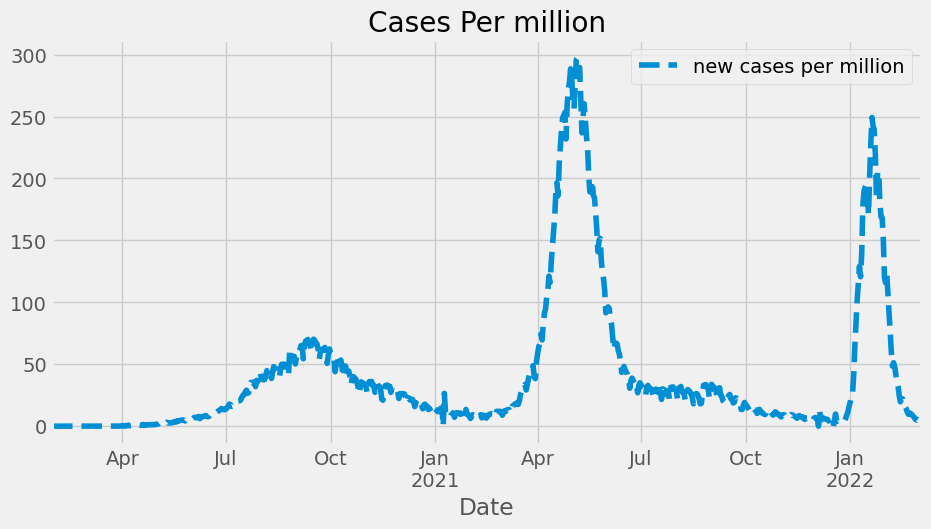

In [124]:
color_pal = sns.color_palette()
asia_1.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()

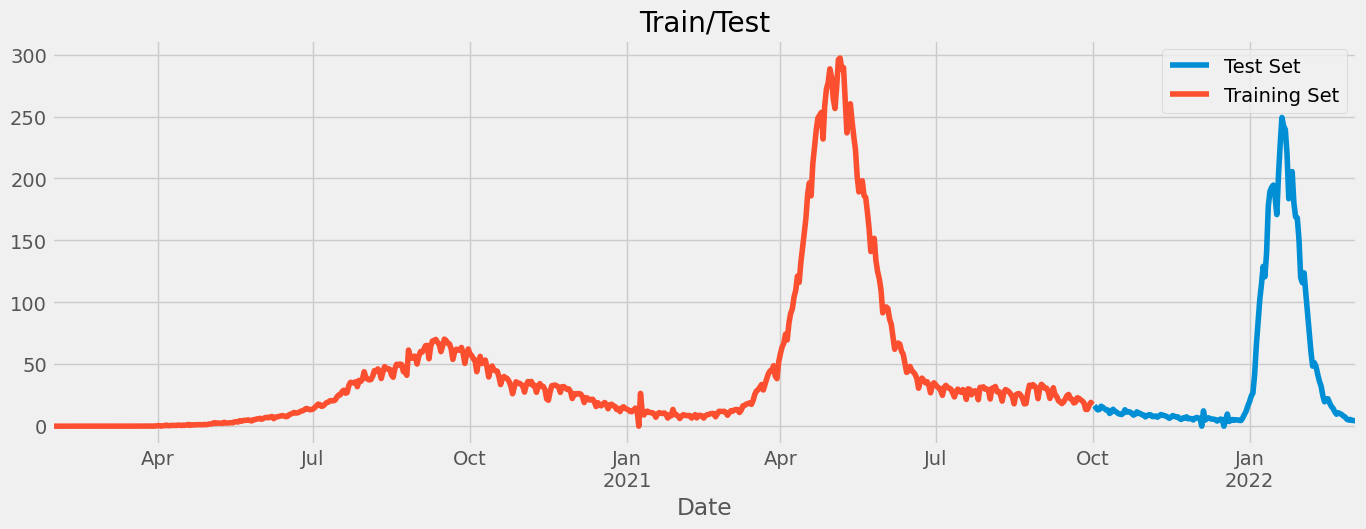

In [125]:
split_date='01-oct-2021'

asia_train1 = asia_1.loc[asia_1.index <=split_date].copy()
asia_test1 = asia_1.loc[asia_1.index >split_date].copy()

asia_test1 \
          .rename(columns={"new cases per million": 'Test Set'}) \
          .join(asia_train1.rename(columns={"new cases per million": 'Training Set'}),
                how='outer') \
          .plot(figsize=(15,5), title='Train/Test')
plt.show()

In [126]:
# Rename columns as required by Prophet
dataasia_1 = asia_train1.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [127]:
# Rename columns as required by Prophet
datetest_asia1 = asia_test1.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [128]:
# Define function to evaluate model performance
def evaluate_model(predictions_asia1, actual_asia1):
    mse_asia1 = mean_squared_error(actual_asia1, predictions_asia1)
    rmse_asia1 = np.sqrt(mse_asia1)
    mape_asia1 = np.mean(np.abs((actual_asia1 - predictions_asia1) / actual_asia1)) * 100
    return mse_asia1, rmse_asia1, mape_asia1

In [129]:
# Initialize and fit the Prophet model on train data
model_asia1 = Prophet()
model_asia1.fit(dataasia_1)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7m6fu76/awg8df5z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7m6fu76/5jb5rg7b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92744', 'data', 'file=/tmp/tmpg7m6fu76/awg8df5z.json', 'init=/tmp/tmpg7m6fu76/5jb5rg7b.json', 'output', 'file=/tmp/tmpg7m6fu76/prophet_modelukmrenud/prophet_model-20230412021346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:13:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:13:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [130]:
n_days_asia1 = 365

In [131]:
future_dates_asia1 = model_asia1.make_future_dataframe(periods=n_days_asia1)

In [132]:
# Use the trained model to make predictions for the next n_days
forecast_asia1 = model_asia1.predict(future_dates_asia1)
# Access the 'yhat_lower' column
forecast_asia1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-30,-0.363025,-52.914857,52.704757
1,2020-01-31,-0.363278,-50.244101,46.293491
2,2020-02-01,-0.422971,-56.227245,50.057498
3,2020-02-02,-2.245886,-53.140171,54.091189
4,2020-02-03,-6.420936,-62.276790,46.368293
...,...,...,...,...
971,2022-09-27,-296.146769,-435.589842,-150.479848
972,2022-09-28,-294.115958,-437.085758,-150.444853
973,2022-09-29,-295.346219,-437.485951,-148.986455
974,2022-09-30,-296.299451,-437.927432,-146.534466


In [133]:
# Plot the forecast
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
fig = plot_plotly(model_asia1, forecast_asia1)
fig.show()

In [134]:
# Evaluate model performance on test data
test_predictions_asia1 = model_asia1.predict(datetest_asia1[['ds']])
test_predictions_asia1 = test_predictions_asia1[['ds', 'yhat']]
test_predictions_asia1 = test_predictions_asia1.merge(datetest_asia1, on='ds')
test_predictions_asia1 = test_predictions_asia1[['yhat', 'y']]
mse_asia1, rmse_asia1, mape_asia1 = evaluate_model(test_predictions_asia1['yhat'], test_predictions_asia1['y'])

In [135]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse_asia1:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_asia1:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_asia1:.2f}%')


Mean Squared Error (MSE): 18688.53
Root Mean Squared Error (RMSE): 136.71
Mean Absolute Percentage Error (MAPE): inf%


In [136]:
asia_2=create_df(data,'Afghanistan')

In [137]:
asia_2=asia_2.loc[:,['Date',"new cases per million"]]
asia_2=asia_2.set_index('Date')

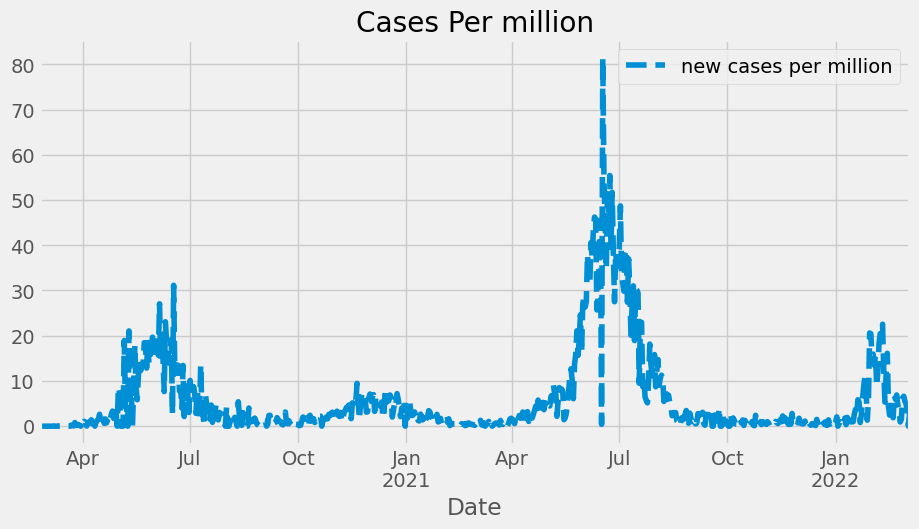

In [138]:
color_pal = sns.color_palette()
asia_2.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()

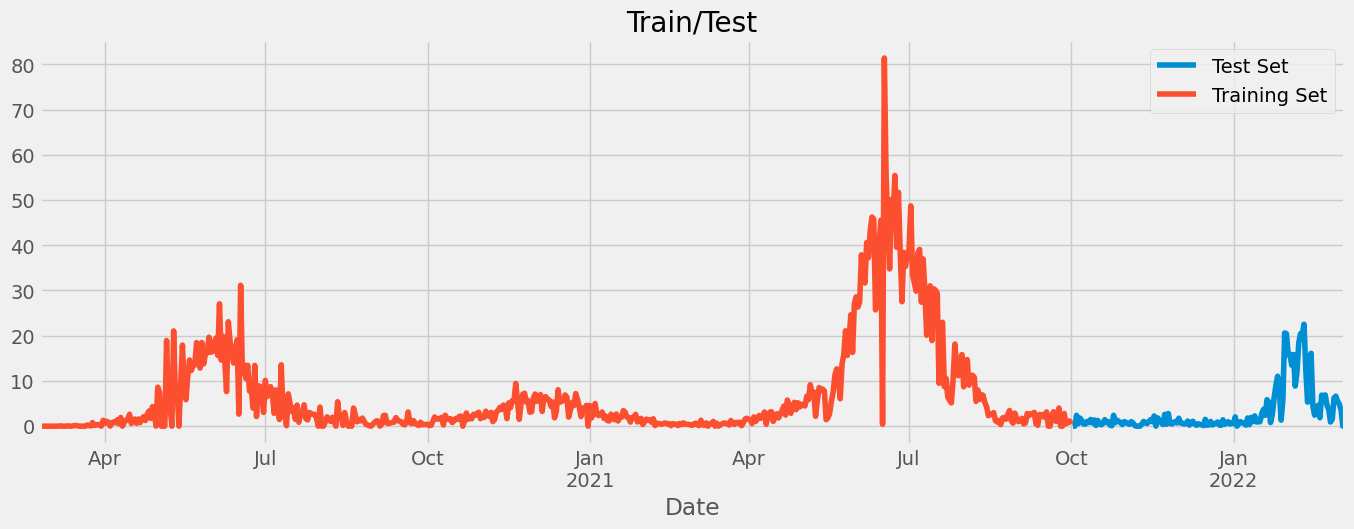

In [139]:
split_date='01-oct-2021'

asia_train2 = asia_2.loc[asia_2.index <=split_date].copy()
asia_test2 = asia_2.loc[asia_2.index >split_date].copy()

asia_test2 \
          .rename(columns={"new cases per million": 'Test Set'}) \
          .join(asia_train2.rename(columns={"new cases per million": 'Training Set'}),
                how='outer') \
          .plot(figsize=(15,5), title='Train/Test')
plt.show()

In [140]:
# Rename columns as required by Prophet
dataasia_2 = asia_train2.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [141]:
# Rename columns as required by Prophet
datetest_asia2 = asia_test2.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [142]:
# Define function to evaluate model performance
def evaluate_model(predictions_asia2, actual_asia2):
    mse_asia2 = mean_squared_error(actual_asia2, predictions_asia2)
    rmse_asia2 = np.sqrt(mse_asia2)
    mape_asia2 = np.mean(np.abs((actual_asia2 - predictions_asia2) / actual_asia2)) * 100
    return mse_asia2, rmse_asia2, mape_asia2

In [143]:
# Initialize and fit the Prophet model on train data
model_asia2 = Prophet()
model_asia2.fit(dataasia_2)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7m6fu76/drp16yi1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7m6fu76/w8ixa5u2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22589', 'data', 'file=/tmp/tmpg7m6fu76/drp16yi1.json', 'init=/tmp/tmpg7m6fu76/w8ixa5u2.json', 'output', 'file=/tmp/tmpg7m6fu76/prophet_model2ql_ay1c/prophet_model-20230412021347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:13:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:13:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [144]:
n_days_asia2 = 365

In [145]:
future_dates_asia2 = model_asia2.make_future_dataframe(periods=n_days_asia2)

In [146]:
# Use the trained model to make predictions for the next n_days
forecast_asia2 = model_asia2.predict(future_dates_asia2)
# Access the 'yhat_lower' column
forecast_asia2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-02-24,1.290610,-8.563962,11.209743
1,2020-02-25,1.757454,-7.840178,11.510203
2,2020-02-26,1.660429,-8.978805,11.007031
3,2020-02-27,2.071125,-7.376825,11.888255
4,2020-02-28,2.821327,-6.736731,12.894585
...,...,...,...,...
946,2022-09-27,-52.183531,-93.235340,-8.414541
947,2022-09-28,-52.484628,-93.309886,-6.176941
948,2022-09-29,-52.278004,-94.150915,-7.856526
949,2022-09-30,-51.731873,-94.269787,-7.613655


In [147]:
# Plot the forecast
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
fig = plot_plotly(model_asia2, forecast_asia2)
fig.show()

In [148]:
# Evaluate model performance on test data
test_predictions_asia2 = model_asia2.predict(datetest_asia2[['ds']])
test_predictions_asia2 = test_predictions_asia2[['ds', 'yhat']]
test_predictions_asia2 = test_predictions_asia2.merge(datetest_asia2, on='ds')
test_predictions_asia2 = test_predictions_asia2[['yhat', 'y']]
mse_asia2, rmse_asia2, mape_asia2 = evaluate_model(test_predictions_asia2['yhat'], test_predictions_asia2['y'])

In [149]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse_asia2:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_asia2:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_asia2:.2f}%')

Mean Squared Error (MSE): 246.54
Root Mean Squared Error (RMSE): 15.70
Mean Absolute Percentage Error (MAPE): inf%


In [150]:
#AFRICA

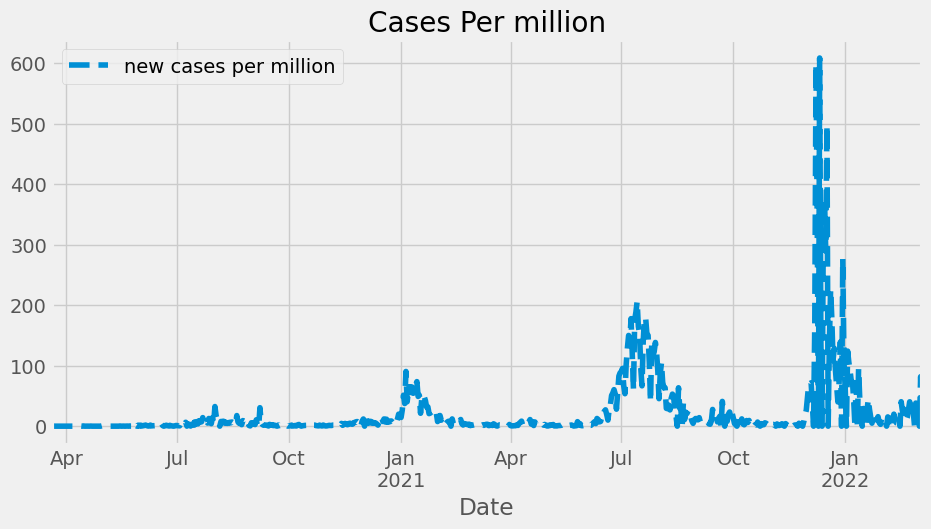

In [151]:
africa_1=create_df(data,'Zimbabwe')

africa_1=africa_1.loc[:,['Date',"new cases per million"]]
africa_1=africa_1.set_index('Date')

color_pal = sns.color_palette()
africa_1.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()

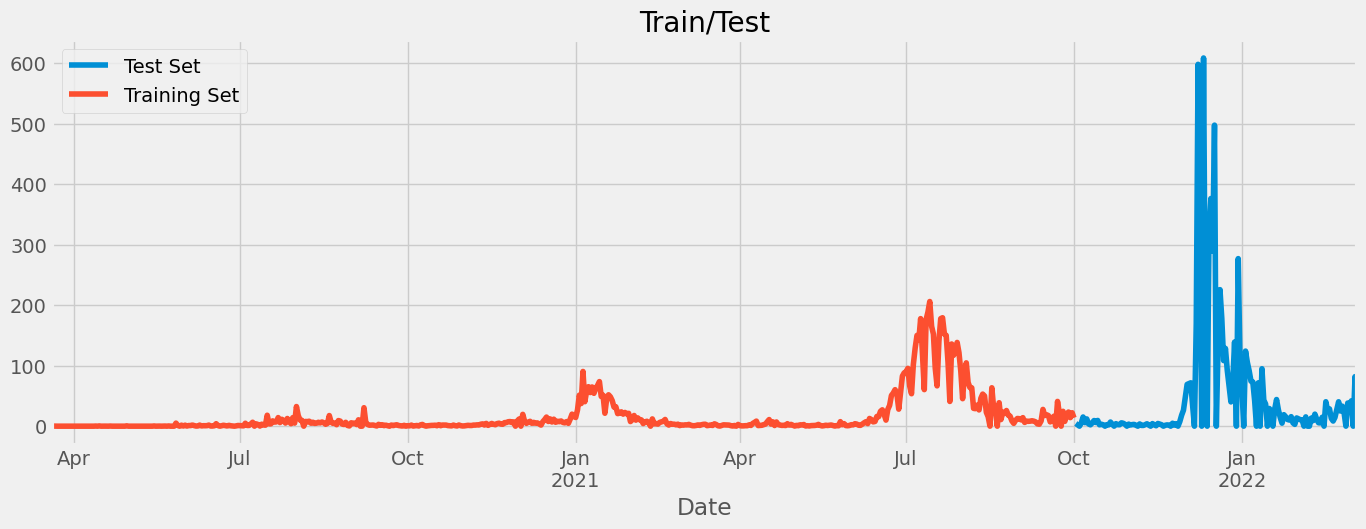

In [152]:
split_date='01-oct-2021'

africa_train1 = africa_1.loc[africa_1.index <=split_date].copy()
africa_test1 = africa_1.loc[africa_1.index >split_date].copy()

africa_test1 \
          .rename(columns={"new cases per million": 'Test Set'}) \
          .join(africa_train1.rename(columns={"new cases per million": 'Training Set'}),
                how='outer') \
          .plot(figsize=(15,5), title='Train/Test')
plt.show()


In [153]:
# Rename columns as required by Prophet
dataafrica_1 = africa_train1.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [154]:
# Rename columns as required by Prophet
datetest_africa1 = africa_test1.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [155]:
# Define function to evaluate model performance
def evaluate_model(predictions_africa1, actual_africa1):
    mse_africa1 = mean_squared_error(actual_africa1, predictions_africa1)
    rmse_africa1 = np.sqrt(mse_africa1)
    mape_africa1 = np.mean(np.abs((actual_africa1 - predictions_africa1) / actual_africa1)) * 100
    return mse_africa1, rmse_africa1, mape_africa1

In [156]:
# Initialize and fit the Prophet model on train data
model_africa1 = Prophet()
model_africa1.fit(dataafrica_1)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7m6fu76/jklrr38t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7m6fu76/qgi_18zp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43743', 'data', 'file=/tmp/tmpg7m6fu76/jklrr38t.json', 'init=/tmp/tmpg7m6fu76/qgi_18zp.json', 'output', 'file=/tmp/tmpg7m6fu76/prophet_modelfkllcrt3/prophet_model-20230412021348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:13:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:13:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [157]:
n_days_africa1 = 365

In [158]:
future_dates_africa1 = model_africa1.make_future_dataframe(periods=n_days_africa1)

In [159]:
# Use the trained model to make predictions for the next n_days
forecast_africa1 = model_africa1.predict(future_dates_africa1)
# Access the 'yhat_lower' column
forecast_africa1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-03-20,-1.602228,-36.561992,34.092911
1,2020-03-21,-4.769725,-43.251602,29.468105
2,2020-03-22,-9.502903,-46.044628,26.548832
3,2020-03-23,-3.036949,-41.294653,32.828909
4,2020-03-24,0.106167,-35.579891,39.370352
...,...,...,...,...
921,2022-09-27,104.917388,66.635374,142.770212
922,2022-09-28,105.022937,65.564414,142.223034
923,2022-09-29,104.687367,66.114797,140.329677
924,2022-09-30,103.865601,67.800319,142.063655


In [160]:
# Plot the forecast
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
fig = plot_plotly(model_africa1, forecast_africa1)
fig.show()

In [161]:
# Evaluate model performance on test data
test_predictions_africa1 = model_africa1.predict(datetest_africa1[['ds']])
test_predictions_africa1 = test_predictions_africa1[['ds', 'yhat']]
test_predictions_africa1 = test_predictions_africa1.merge(datetest_africa1, on='ds')
test_predictions_africa1 = test_predictions_africa1[['yhat', 'y']]
mse_africa1, rmse_africa1, mape_africa1 = evaluate_model(test_predictions_africa1['yhat'], test_predictions_africa1['y'])

In [162]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse_africa1:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_africa1:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_africa1:.2f}%')

Mean Squared Error (MSE): 9828.75
Root Mean Squared Error (RMSE): 99.14
Mean Absolute Percentage Error (MAPE): inf%


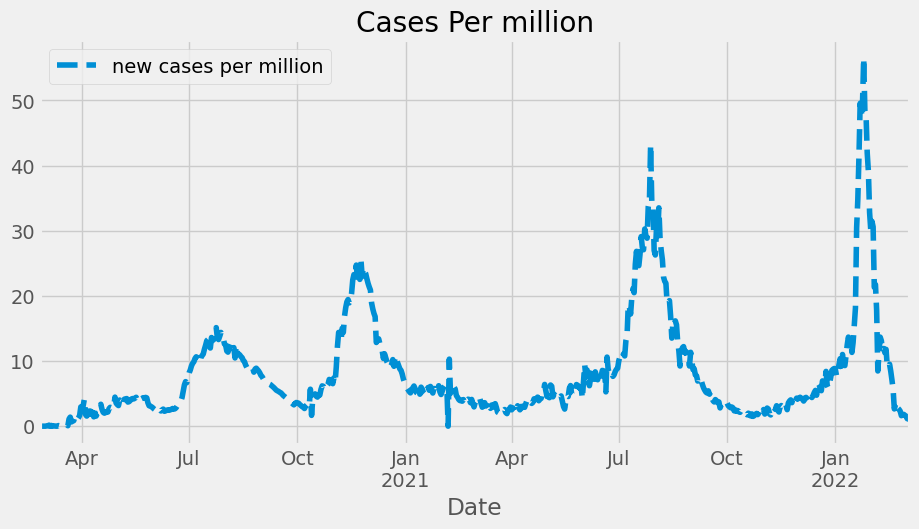

In [163]:
africa_2=create_df(data,'Algeria')

africa_2=africa_2.loc[:,['Date',"new cases per million"]]
africa_2=africa_2.set_index('Date')

color_pal = sns.color_palette()
africa_2.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()

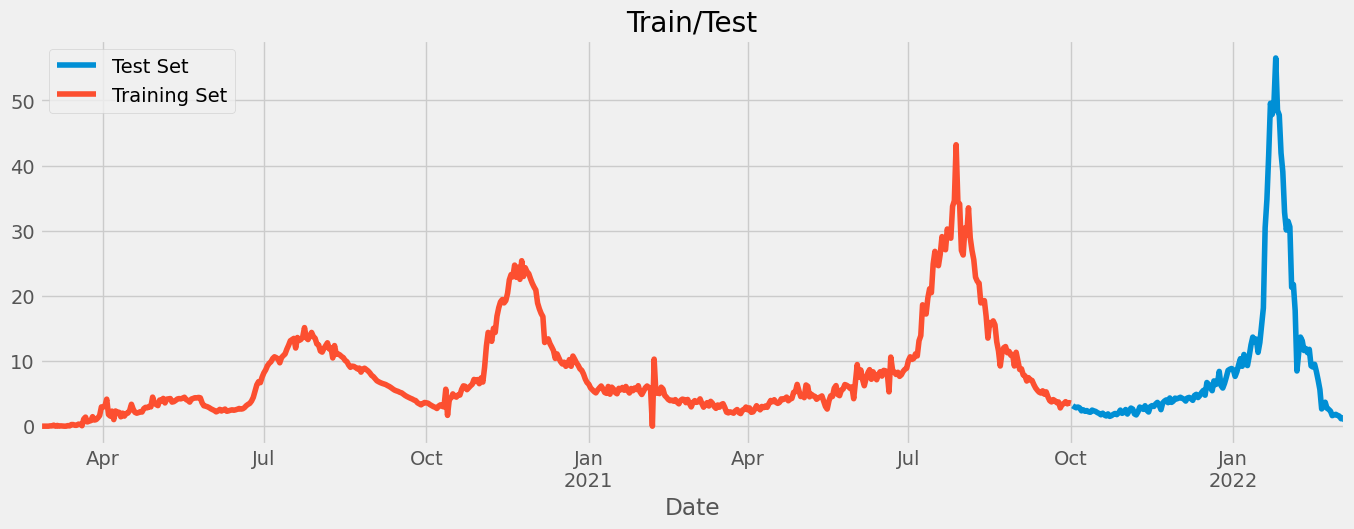

In [164]:
split_date='01-oct-2021'

africa_train2 = africa_2.loc[africa_2.index <=split_date].copy()
africa_test2 = africa_2.loc[africa_2.index >split_date].copy()

africa_test2 \
          .rename(columns={"new cases per million": 'Test Set'}) \
          .join(africa_train2.rename(columns={"new cases per million": 'Training Set'}),
                how='outer') \
          .plot(figsize=(15,5), title='Train/Test')
plt.show()

In [165]:
# Rename columns as required by Prophet
dataafrica_2 = africa_train2.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [166]:
# Rename columns as required by Prophet
datetest_africa2 = africa_test2.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [167]:
# Define function to evaluate model performance
def evaluate_model(predictions_africa2, actual_africa2):
    mse_africa2 = mean_squared_error(actual_africa2, predictions_africa2)
    rmse_africa2 = np.sqrt(mse_africa2)
    mape_africa2 = np.mean(np.abs((actual_africa2 - predictions_africa2) / actual_africa2)) * 100
    return mse_africa2, rmse_africa2, mape_africa2


In [168]:
# Initialize and fit the Prophet model on train data
model_africa2 = Prophet()
model_africa2.fit(dataafrica_2)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7m6fu76/y67xghqy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7m6fu76/ki8n76ic.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12887', 'data', 'file=/tmp/tmpg7m6fu76/y67xghqy.json', 'init=/tmp/tmpg7m6fu76/ki8n76ic.json', 'output', 'file=/tmp/tmpg7m6fu76/prophet_modelnnovmjkz/prophet_model-20230412021349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:13:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:13:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [169]:
n_days_africa2 = 365

In [170]:
future_dates_africa2 = model_africa2.make_future_dataframe(periods=n_days_africa2)

In [171]:
# Use the trained model to make predictions for the next n_days
forecast_africa2 = model_africa2.predict(future_dates_africa2)
# Access the 'yhat_lower' column
forecast_africa2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-02-25,1.226024,-6.273554,8.595389
1,2020-02-26,1.491213,-6.313364,8.962815
2,2020-02-27,1.401097,-6.314253,9.291703
3,2020-02-28,1.555532,-5.979413,8.945639
4,2020-02-29,1.071507,-6.363424,9.087201
...,...,...,...,...
945,2022-09-27,28.204048,18.342104,37.746134
946,2022-09-28,28.468854,19.209366,38.760844
947,2022-09-29,28.378354,18.409814,38.232809
948,2022-09-30,28.532406,18.451375,37.722026


In [172]:
# Plot the forecast
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
fig = plot_plotly(model_africa2, forecast_africa2)
fig.show()

In [173]:
# Evaluate model performance on test data
test_predictions_africa2 = model_africa2.predict(datetest_africa2[['ds']])
test_predictions_africa2 = test_predictions_africa2[['ds', 'yhat']]
test_predictions_africa2 = test_predictions_africa2.merge(datetest_africa2, on='ds')
test_predictions_africa2 = test_predictions_africa2[['yhat', 'y']]
mse_africa2, rmse_africa2, mape_africa2 = evaluate_model(test_predictions_africa2['yhat'], test_predictions_africa2['y'])


In [174]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse_africa2:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_africa2:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_africa2:.2f}%')

Mean Squared Error (MSE): 184.00
Root Mean Squared Error (RMSE): 13.56
Mean Absolute Percentage Error (MAPE): 358.33%


In [175]:
#NorthAmerica

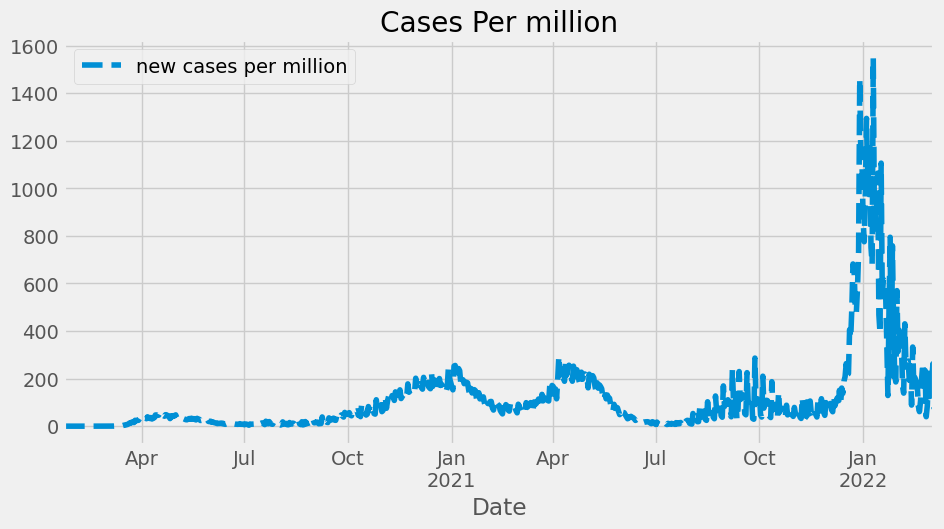

In [176]:
northamerica_1=create_df(data,'Canada')

northamerica_1=northamerica_1.loc[:,['Date',"new cases per million"]]
northamerica_1=northamerica_1.set_index('Date')

color_pal = sns.color_palette()
northamerica_1.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()

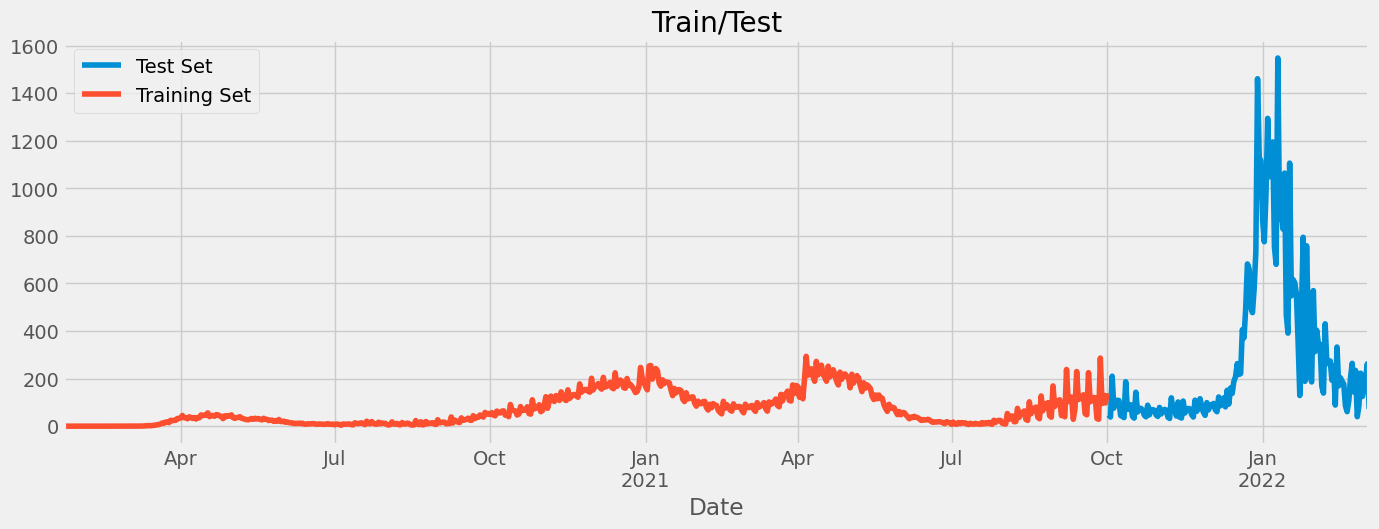

In [177]:
split_date='01-oct-2021'

northamerica_train1 = northamerica_1.loc[northamerica_1.index <=split_date].copy()
northamerica_test1 = northamerica_1.loc[northamerica_1.index >split_date].copy()

northamerica_test1 \
          .rename(columns={"new cases per million": 'Test Set'}) \
          .join(northamerica_train1.rename(columns={"new cases per million": 'Training Set'}),
                how='outer') \
          .plot(figsize=(15,5), title='Train/Test')
plt.show()

In [178]:
# Rename columns as required by Prophet
datanorthamerica_1 = northamerica_train1.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})


In [179]:
# Rename columns as required by Prophet
datetest_northamerica1 = northamerica_test1.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [180]:
# Define function to evaluate model performance
def evaluate_model(predictions_northamerica1, actual_northamerica1):
    mse_northamerica1 = mean_squared_error(actual_northamerica1, predictions_northamerica1)
    rmse_northamerica1 = np.sqrt(mse_northamerica1)
    mape_northamerica1 = np.mean(np.abs((actual_northamerica1 - predictions_northamerica1) / actual_northamerica1)) * 100
    return mse_northamerica1, rmse_northamerica1, mape_northamerica1


In [181]:
# Initialize and fit the Prophet model on train data
model_northamerica1 = Prophet()
model_northamerica1.fit(datanorthamerica_1)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7m6fu76/d7wjregm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7m6fu76/8txtzt5b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53894', 'data', 'file=/tmp/tmpg7m6fu76/d7wjregm.json', 'init=/tmp/tmpg7m6fu76/8txtzt5b.json', 'output', 'file=/tmp/tmpg7m6fu76/prophet_modelt0pyrey8/prophet_model-20230412021351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:13:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:13:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [182]:
n_days_northamerica1 = 365

In [183]:
future_dates_northamerica1 = model_northamerica1.make_future_dataframe(periods=n_days_northamerica1)

In [184]:
# Use the trained model to make predictions for the next n_days
forecast_northamerica1 = model_northamerica1.predict(future_dates_northamerica1)
# Access the 'yhat_lower' column
forecast_northamerica1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-23,1.092283,-63.264569,61.277434
1,2020-01-24,1.273408,-59.502542,59.066872
2,2020-01-25,-15.049492,-72.669309,40.442359
3,2020-01-26,-18.223129,-83.201276,41.120255
4,2020-01-27,9.911273,-54.823973,67.587150
...,...,...,...,...
978,2022-09-27,-67.028948,-169.734199,28.713245
979,2022-09-28,-67.170527,-176.691497,32.820841
980,2022-09-29,-64.892482,-167.894208,32.912608
981,2022-09-30,-65.249615,-173.150273,38.534290


In [185]:
# Plot the forecast
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
fig = plot_plotly(model_northamerica1, forecast_northamerica1)
fig.show()

In [186]:
# Evaluate model performance on test data
test_predictions_northamerica1 = model_northamerica1.predict(datetest_northamerica1[['ds']])
test_predictions_northamerica1 = test_predictions_northamerica1[['ds', 'yhat']]
test_predictions_northamerica1 = test_predictions_northamerica1.merge(datetest_northamerica1, on='ds')
test_predictions_northamerica1 = test_predictions_northamerica1[['yhat', 'y']]
mse_northamerica1, rmse_northamerica1, mape_northamerica1 = evaluate_model(test_predictions_northamerica1['yhat'], test_predictions_northamerica1['y'])

In [187]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse_northamerica1:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_northamerica1:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_northamerica1:.2f}%')

Mean Squared Error (MSE): 178783.48
Root Mean Squared Error (RMSE): 422.83
Mean Absolute Percentage Error (MAPE): 69.52%


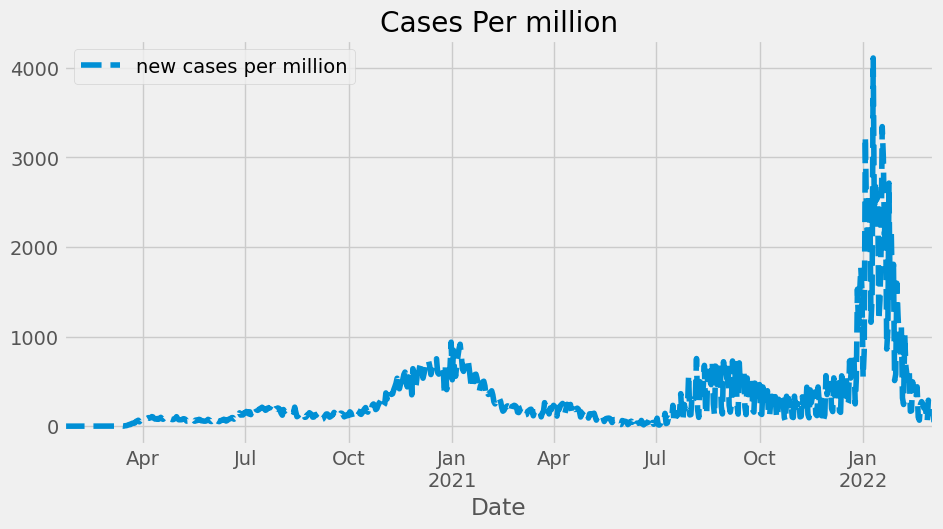

In [188]:
northamerica_2=create_df(data,"United States")

northamerica_2=northamerica_2.loc[:,['Date',"new cases per million"]]
northamerica_2=northamerica_2.set_index('Date')

color_pal = sns.color_palette()
northamerica_2.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()


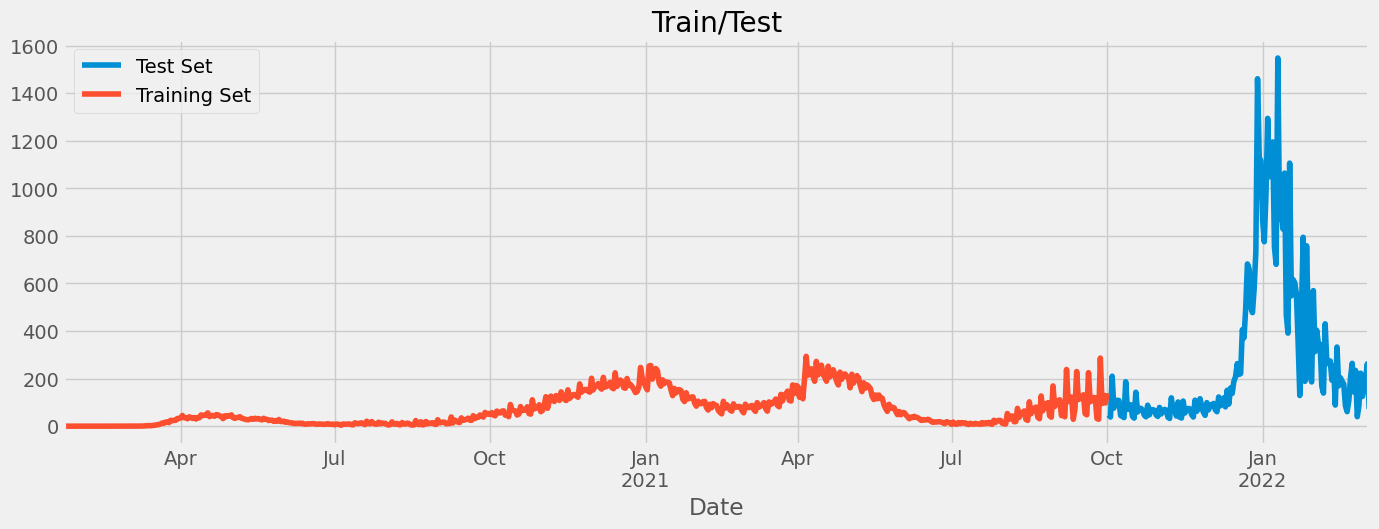

In [189]:
split_date='01-oct-2021'

northamerica_train2 = northamerica_2.loc[northamerica_2.index <=split_date].copy()
northamerica_test2 = northamerica_2.loc[northamerica_2.index >split_date].copy()

northamerica_test1 \
          .rename(columns={"new cases per million": 'Test Set'}) \
          .join(northamerica_train1.rename(columns={"new cases per million": 'Training Set'}),
                how='outer') \
          .plot(figsize=(15,5), title='Train/Test')
plt.show()


In [190]:

# Rename columns as required by Prophet
datanorthamerica_2 = northamerica_train2.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})


In [191]:
# Rename columns as required by Prophet
datetest_northamerica2 = northamerica_test2.groupby('Date').sum("new cases per million").reset_index() \
      .rename(columns={'Date': 'ds', "new cases per million": 'y'})

In [192]:
# Define function to evaluate model performance
def evaluate_model(predictions_northamerica2, actual_northamerica2):
    mse_northamerica2 = mean_squared_error(actual_northamerica2, predictions_northamerica2)
    rmse_northamerica2 = np.sqrt(mse_northamerica1)
    mape_northamerica2 = np.mean(np.abs((actual_northamerica2 - predictions_northamerica2) / actual_northamerica2)) * 100
    return mse_northamerica2, rmse_northamerica2, mape_northamerica2

In [193]:
# Initialize and fit the Prophet model on train data
model_northamerica2 = Prophet()
model_northamerica2.fit(datanorthamerica_2)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7m6fu76/chpqkzhb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7m6fu76/43hmyzqi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76323', 'data', 'file=/tmp/tmpg7m6fu76/chpqkzhb.json', 'init=/tmp/tmpg7m6fu76/43hmyzqi.json', 'output', 'file=/tmp/tmpg7m6fu76/prophet_modelnjroghy_/prophet_model-20230412021352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:13:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:13:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [194]:
n_days_northamerica2 = 365

In [195]:
future_dates_northamerica2 = model_northamerica2.make_future_dataframe(periods=n_days_northamerica2)

In [196]:
# Use the trained model to make predictions for the next n_days
forecast_northamerica2 = model_northamerica2.predict(future_dates_northamerica2)
# Access the 'yhat_lower' column
forecast_northamerica2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-22,-8.792936,-155.555040,120.876765
1,2020-01-23,0.267404,-133.463983,146.865218
2,2020-01-24,34.109046,-106.946586,173.037321
3,2020-01-25,-34.698990,-172.394775,107.052750
4,2020-01-26,-76.868271,-219.596189,67.916685
...,...,...,...,...
979,2022-09-27,1405.610919,649.404745,2214.058060
980,2022-09-28,1421.111018,667.731176,2221.378058
981,2022-09-29,1432.032319,670.733833,2249.556432
982,2022-09-30,1467.734922,717.621888,2263.592308


In [197]:
# Plot the forecast
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
fig = plot_plotly(model_northamerica2, forecast_northamerica2)
fig.show()

In [198]:
# Evaluate model performance on test data
test_predictions_northamerica2 = model_northamerica2.predict(datetest_northamerica2[['ds']])
test_predictions_northamerica2 = test_predictions_northamerica2[['ds', 'yhat']]
test_predictions_northamerica2 = test_predictions_northamerica2.merge(datetest_northamerica2, on='ds')
test_predictions_northamerica2 = test_predictions_northamerica2[['yhat', 'y']]
mse_northamerica2, rmse_northamerica2, mape_northamerica2 = evaluate_model(test_predictions_northamerica2['yhat'], test_predictions_northamerica2['y'])

In [199]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse_northamerica2:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_northamerica2:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_northamerica2:.2f}%')

Mean Squared Error (MSE): 583197.93
Root Mean Squared Error (RMSE): 422.83
Mean Absolute Percentage Error (MAPE): 157.82%


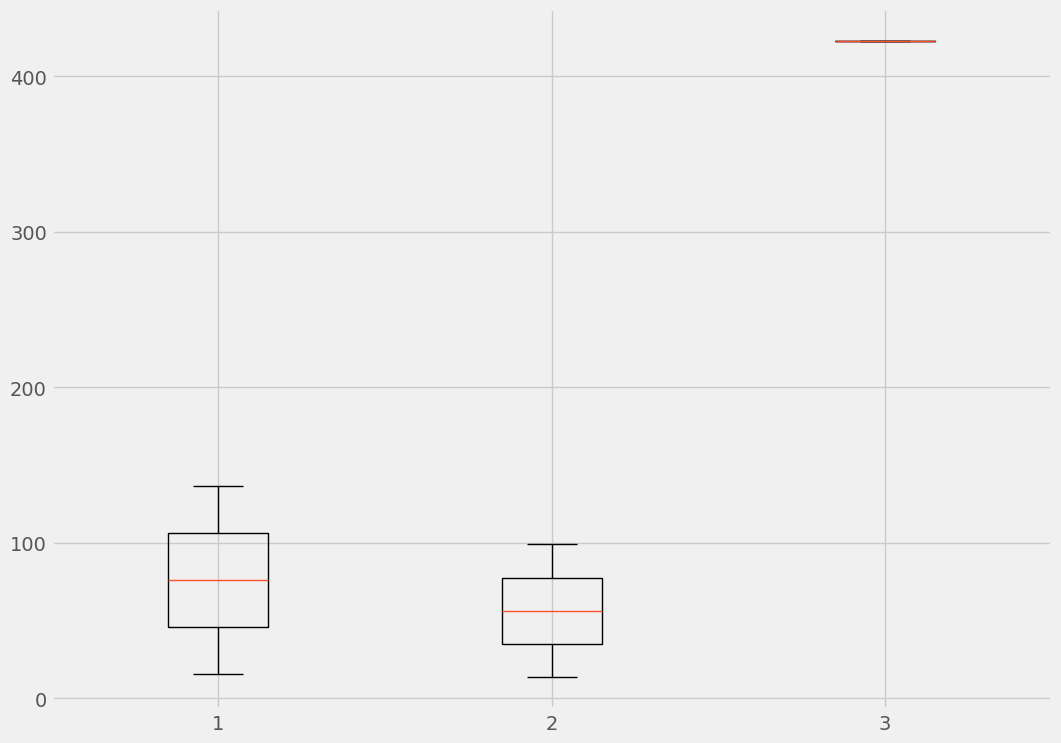

In [200]:
#RMSE

rmse_asia=(rmse_asia1,rmse_asia2)
rmse_africa=(rmse_africa1,rmse_africa2)
rmse_northamerica=(rmse_northamerica1,rmse_northamerica2)

rmse_all=[rmse_asia,rmse_africa,rmse_northamerica]


fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(rmse_all)
 
# show plot
plt.show()


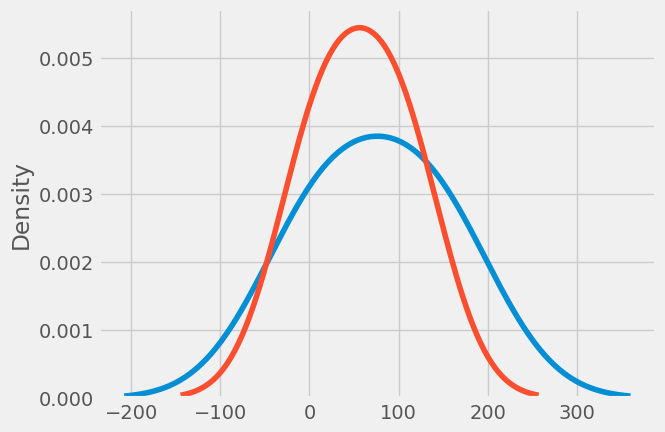

In [201]:
# Create a density distribution

sns.kdeplot(rmse_asia, label='RMSE 1')
sns.kdeplot(rmse_africa, label='RMSE 2')
sns.kdeplot(rmse_northamerica, label='RMSE 3')

# Show the plot
import matplotlib.pyplot as plt
plt.show()